todo: 
+ split this apart into multiple steps, and document each one.
+ get time-series data to Ben
+ put this into an AWS instance with 64GB memory and crank the results out (is a lambda practical?)

In [1]:
from knowknow import *

In [2]:
from knowknow.datasources import jstor

In [4]:
class sparse_counter( jstor.jstor_counter ):

    def account_for(self, doc):

        # year
        self.cnt(doc['year'], 'fy', doc['doi'])

        # journal
        self.cnt(doc['journal'], 'fj', doc['doi'])

        # journal year
        self.cnt((doc['journal'], doc['year']), 'fj.fy', doc['doi'])

        # constructing the tuples set :)
        sp = doc['content'].lower() # debating lowercaseing..
        sp = re.sub("[^a-zA-Z\s]+", "", sp)  # removing extraneous characters
        sp = re.sub("\s+", " ", sp)  # removing extra characters
        sp = sp.strip()
        sp = sp.split()  # splitting into words

        sp = [x for x in sp if x not in self.stopwords]  # strip stopwords
        sp = [x for x in sp if len(x) >= 3 ] # strip short words

        # print(len(tups),c['contextPure'], "---", tups)

        tups = set("-".join(list(x)) for x in set(zip(sp[:-1], sp[1:])))  # two-word *ordered* tuples
        tups.update(sp)  # one-word tuples

        if len(self.term_whitelist):
            tups = [x for x in tups if x in self.term_whitelist]

        # just term count, in case we are using the `basic` mode
        for t1 in tups:
            # term
            self.cnt((t1,), 't', doc['doi'])
            # term journal
            #self.cnt((doc['journal'], t1), 'fj.t', doc['doi'])
            # term year
            #self.cnt((doc['year'], t1), 'fy.t', doc['doi'])
            
            # year
            self.cnt(doc['year'], 'fy', doc['doi'])

            # journal
            self.cnt(doc['journal'], 'fj', doc['doi'])

In [5]:
c = sparse_counter(
    jstor_zip_base = "G:/My Drive/2020 ORGANISATION/1. PROJECTS/qualitative analysis of literature/110 CITATION ANALYSIS/000 data/sociology jstor",
    #jstor_zip_base = "Z:/google_drive/1. PROJECTS/qualitative analysis of literature/110 CITATION ANALYSIS/000 data/sociology jstor",
    output_database = 'sociology-jstor-sparse-simple',
    RUN_EVERYTHING=False, SKIP_N = 10*5 - 1
)

In [6]:
c.count()

Will print updated statistics every 20 documents.
Iterating over  248380 documents
Document 0 ... 0 journals... 0 cited works... 0 authors... 0 terms used... 0 'social' terms
Document 20 ... 12 journals... 0 cited works... 0 authors... 59319 terms used... 15 'social' terms
Document 40 ... 17 journals... 0 cited works... 0 authors... 117122 terms used... 28 'social' terms
Document 60 ... 24 journals... 0 cited works... 0 authors... 160704 terms used... 41 'social' terms
Document 80 ... 28 journals... 0 cited works... 0 authors... 220443 terms used... 56 'social' terms
Document 100 ... 31 journals... 0 cited works... 0 authors... 269294 terms used... 68 'social' terms
Document 120 ... 31 journals... 0 cited works... 0 authors... 307610 terms used... 81 'social' terms
Document 140 ... 33 journals... 0 cited works... 0 authors... 359061 terms used... 96 'social' terms
Document 160 ... 35 journals... 0 cited works... 0 authors... 395198 terms used... 109 'social' terms
Document 180 ... 37 j

In [7]:
c.output_database

'sociology-jstor-sparse-simple'

In [8]:
len(c.doc['t'])

2605589

In [9]:
c.save_counters()

loading variable sociology-jstor-sparse-simple/_attributes from disk
loading variable sociology-jstor-sparse-simple/groups from disk


# setting date range

In [10]:
from knowknow import *

In [11]:
c = Dataset('sociology-jstor-sparse-simple')

loading variable sociology-jstor-sparse-simple/groups from disk


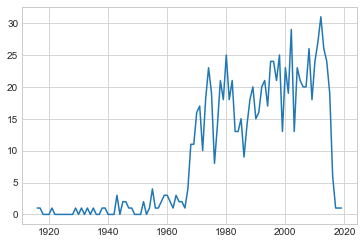

In [21]:
by_y = c.by('fy').docs
ys = sorted(by_y.keys())
ys = range(ys[0].fy, ys[-1].fy+1)
cs = [by_y[(y,)] for y in ys]

plt.plot(ys,cs)

In [13]:
c.set_attribute('RELIABLE_DATA_STARTS_HERE', 1970)
c.set_attribute('RELIABLE_DATA_ENDS_HERE', 2015)

# first filter based on number of times each term was mentioned

We want this to be as wide a net we can stand for the next filtering processes.
I cannot keep track of yearly counts of all terms, or even simple term counts (at least, not without dynamic consolidation), because of RAM limitations.
Remember that I'm keeping track of all words, but also all two-word tuples!
So this first stage is only using 1/10 of the documents (see above, SKIP_N).

<!--At this point, subsetting the data now that we have a terms list will not help our memory issue.-->
The term-term coocurrence network uses N^2 integers, which with 1M terms is 1M^2 = 1TB of memory.
If we can limit to ~30,000 terms, approximately the working vocabulary of an adult, this would fit in 1GB of memory.
We can filter by term *dynamics* instead of just relying on .
We can also limit the 1-tuples and 2-tuples independently, reserving 15,000 terms for each.
2-tuples currently make up the majority of our counts, but are not inherently more important than 1-tuples.

In [14]:
#plt.plot([t._dp[y] for y in range(1950,2015)])

In [15]:
target_N = 1000

In [26]:
cc = c.by('t').docs

loading variable sociology-jstor-sparse-simple/doc ___ t from disk


In [27]:
ndocs = sum(c.by('fy').docs.values())
#cutoff_bot = 0.001 # if present in less than 1/1000 of the documents, discard
#cutoff_count = 2 # if present in less than 2 documents, discard
#cutoff_top = 0.500 # if present in more than 50% of documents, discard

assert( not any( c>ndocs for c in cc.values() ) )

#ndoc_bot = cutoff_bot*ndocs
#ndoc_bot = max(cutoff_count, ndoc_bot)

#terms_to_keep = [t for t,c in c.doc['t'].items() if ndoc_bot <= c <= cutoff_top*ndocs]

tups1 = sorted(
    [x for x in cc if '-' not in x[0]], 
    key=lambda x:cc[x]
)[ -target_N//2: ]

tups2 = sorted(
    [x for x in cc if '-' in x[0]], 
    key=lambda x:cc[x]
)[ -target_N//2: ]

terms_to_keep = tups1 + tups2

# entropy over journals

In [29]:
from scipy.stats import entropy

In [30]:
entropy([1/2,1/2])

0.6931471805599453

In [31]:
-1 * .5 * np.log(0.5) * 2

0.6931471805599453

In [32]:
journals = c.items('fj')

ents = []

for (term,) in terms_to_keep:
    a = [ c(t=term, fj=JJ).docs for JJ in journals]
    ents.append( entropy(a) )

loading variable sociology-jstor-sparse-simple/ind ___ fj from disk
loading variable sociology-jstor-sparse-simple/doc ___ fj.t from disk


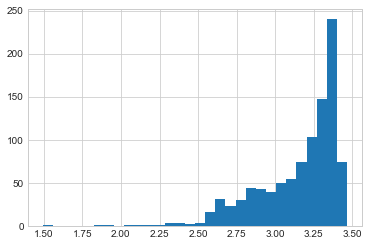

In [33]:
plt.hist(ents, bins=30);

In [34]:
for j in np.argsort(ents)[:30]:
    print(ents[j], terms_to_keep[j])

1.4931160821814595 t(t='carolina-press')
1.530901041002346 t(t='key-words')
1.8816957207549756 t(t='university-north')
1.9157719621028604 t(t='journal-marriage')
1.9294248090380695 t(t='direct-correspondence')
2.055959141225672 t(t='science-review')
2.066456631395096 t(t='scientific-study')
2.0852658743579036 t(t='volume-number')
2.1809209372410616 t(t='north-carolina')
2.2579704209526525 t(t='marriage-family')
2.2980082049192228 t(t='human-development')
2.299894124001868 t(t='family-structure')
2.3234607440687944 t(t='journal-political')
2.3288054804545855 t(t='rights-reserved')
2.3585056159316116 t(t='quality-life')
2.3860430542578563 t(t='american-political')
2.405158370502643 t(t='bureau-census')
2.411138740415502 t(t='prior-research')
2.428223352223742 t(t='test-whether')
2.4572778975936753 t(t='human-capital')
2.4777178723182454 t(t='sex-differences')
2.4878947178518986 t(t='blacks-whites')
2.507056611901298 t(t='sociological-quarterly')
2.512205421027155 t(t='professor-sociology

In [35]:
for j in np.argsort(ents)[-30:]:
    print(ents[j], terms_to_keep[j])

3.42146214573554 t(t='concept')
3.4226313034057068 t(t='say')
3.422853957612925 t(t='thought')
3.4241339017696792 t(t='always')
3.4245696303797795 t(t='social-relations')
3.424716967235051 t(t='knowledge')
3.424796065063742 t(t='perspective')
3.4260708556923456 t(t='never')
3.4261854746330287 t(t='culture')
3.426849270039543 t(t='situation')
3.4274323629875836 t(t='vol')
3.429245030259341 t(t='ones')
3.4321690242300065 t(t='class')
3.432321677623457 t(t='become')
3.4329513815816166 t(t='already')
3.4337998264761747 t(t='world')
3.434703835988382 t(t='like')
3.4352466908071038 t(t='sense')
3.4363294403273694 t(t='position')
3.4377457080802842 t(t='place')
3.4377735860880883 t(t='york')
3.4379068252485703 t(t='special')
3.4384652010868595 t(t='seen')
3.43913405694472 t(t='new-york')
3.4391617371559433 t(t='whole')
3.4411739384961932 t(t='end')
3.445159859326719 t(t='history')
3.4614270810313976 t(t='give')
3.4645037618857386 t(t='introduction')
3.4658349866361933 t(t='understand')


# just number of journals it's mentioned in

In [36]:
journals = c.items('fj')

counts = []

for (term,) in terms_to_keep:
    counts.append( sum(
        c(t=term, fj=JJ).docs > 0 
        for JJ in journals
    ) )

In [37]:
len(journals)

46

(array([  1.,   1.,   1.,   2.,   4.,  13.,  12.,  49.,  48.,  60.,  61.,
         63.,  63.,  20.,  44.,  26.,  30.,  70., 198., 234.]),
 array([ 9.  , 10.85, 12.7 , 14.55, 16.4 , 18.25, 20.1 , 21.95, 23.8 ,
        25.65, 27.5 , 29.35, 31.2 , 33.05, 34.9 , 36.75, 38.6 , 40.45,
        42.3 , 44.15, 46.  ]),
 <a list of 20 Patch objects>)

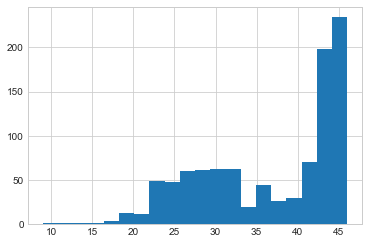

In [38]:
plt.hist(counts, bins=20)

In [39]:
cc = np.array(counts)
for ii in np.argwhere( (cc>20) & (cc<30) ).flatten()[:10]:
    print(counts[ii], ents[ii], terms_to_keep[ii])

22 2.781126340749604 t(t='demographic-characteristics')
28 2.9297019971395204 t(t='help-explain')
27 2.9661292068557166 t(t='political-power')
24 2.955643179321068 t(t='time-time')
21 2.8136825409708073 t(t='noted-earlier')
29 3.1048523758305198 t(t='dependent-upon')
23 2.645580774740674 t(t='life-cycle')
24 2.8595087768233256 t(t='see-figure')
25 2.7819186293430143 t(t='high-rates')
26 2.961251539845244 t(t='racial-ethnic')


In [40]:
cc = np.array(counts)
for ii in np.argsort( cc )[:10]:
    print(counts[ii], ents[ii], terms_to_keep[ii])
for ii in np.argsort( cc )[-10:]:
    print(counts[ii], ents[ii], terms_to_keep[ii])

9 1.530901041002346 t(t='key-words')
12 2.0852658743579036 t(t='volume-number')
14 2.3288054804545855 t(t='rights-reserved')
15 1.9294248090380695 t(t='direct-correspondence')
16 2.4878947178518986 t(t='blacks-whites')
17 2.428223352223742 t(t='test-whether')
17 2.066456631395096 t(t='scientific-study')
18 2.4777178723182454 t(t='sex-differences')
18 2.411138740415502 t(t='prior-research')
19 2.5449549994828446 t(t='change-time')
46 3.3623505980286623 t(t='understanding')
46 3.360995903476422 t(t='groups')
46 3.3787794659206134 t(t='sociological')
46 3.4080174033354704 t(t='people')
46 3.434703835988382 t(t='like')
46 3.3960287504258475 t(t='role')
46 3.356473069673376 t(t='discussion')
46 3.3849474337636623 t(t='state')
46 3.4179654039663787 t(t='society')
46 3.3814546458177026 t(t='one')


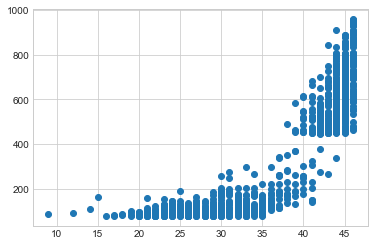

In [41]:
plt.scatter(
    counts,
    [
        c(t=t[0]).docs
        for t in terms_to_keep
    ]
)

# let's investigate

In [43]:
tinv = sample(terms_to_keep, 5)

In [45]:
tinv

[t(t='data-set'),
 t(t='expected'),
 t(t='appears'),
 t(t='specifically'),
 t(t='social-behavior')]

data-set


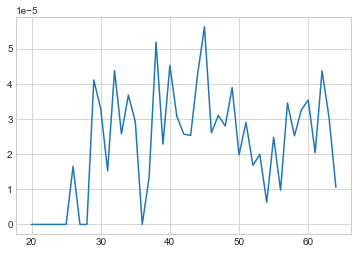

expected


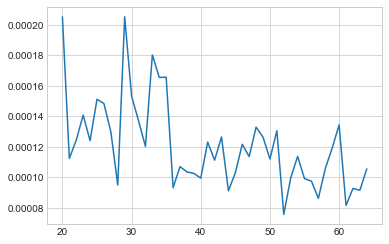

appears


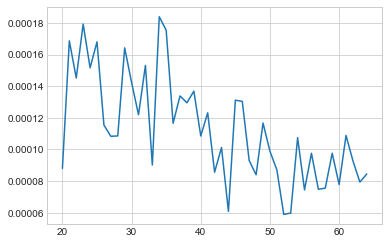

specifically


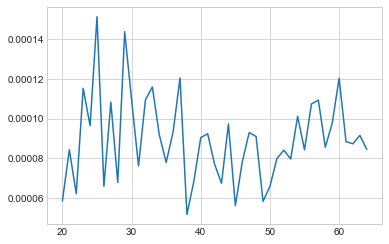

social-behavior


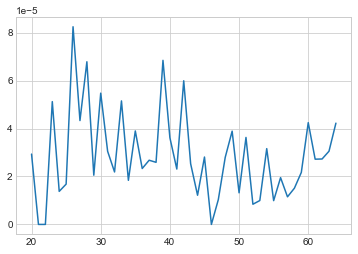

In [46]:
for term, in tinv:
    t = c.trend('t', term)
    print(term)
    plt.plot([t._cp[y] for y in range(1950,2015)])
    plt.show()

In [19]:
term_blacklist = []

In [20]:
term_blacklist += [x for x in c.items('t') if len(x) <=2]

loading variable sociology-jstor-sparse-simple/ind ___ t from disk


In [21]:
len(term_blacklist)

659

In [ ]:
term_blacklist

In [ ]:
term_blacklist = set(term_blacklist)

In [14]:
terms_to_keep = [x[0] for x in terms_to_keep]

In [29]:
from random import sample
print(sample(terms_to_keep, 50))

['indicate', 'one', 'despite', 'recent', 'london-routledge', 'descriptive-statistics', 'ed', 'sociological-theory', 'social-system', 'social-scientists', 'order', 'policy', 'processes', 'article', 'per-cent', 'source', 'sociology-social', 'compared', 'decision-making', 'great-deal', 'high-levels', 'seems', 'cultural', 'j-c', 'seen', 'percent-percent', 'persons', 'among', 'may-seem', 'factor-analysis', 'basis', 'york-mcgrawhill', 'provide', 'two-groups', 'government', 'behavior', 'changing', 'reported-table', 'another-way', 'c-j', 'social-mobility', 'oaks-ca', 'yale-university', 'much-higher', 'provides', 'must', 'literature', 'sample-size', 'institute-social', 'higher-education']


In [31]:
print(f"Reducing the number of terms from {len(cc):0,} to {len(terms_to_keep):0,}.")
#print(f"To those terms present in a minimum of {ndoc_bot} docs, and maximum of {cutoff_top*ndocs} docs.")

Reducing the number of terms from 2,740,481 to 1,000.


In [51]:
import pickle
with open('terms.pickle', 'wb') as outf:
    pickle.dump([x[0] for x in terms_to_keep],outf)

In [ ]:
raise

In [ ]:
# store terms_to_keep

# recount with fuller detail

on my desktop computer this takes way too much time

In [4]:
from knowknow import *

In [5]:
from knowknow.datasources import jstor

In [6]:
class full_counter( jstor.jstor_counter ):
    
    WINDOW = 250

    def account_for(self, doc):

        # year
        self.cnt(doc['year'], 'fy', doc['doi'])

        # journal
        self.cnt(doc['journal'], 'fj', doc['doi'])

        # journal year
        self.cnt((doc['journal'], doc['year']), 'fj.fy', doc['doi'])

        # constructing the tuples set :)
        
        sp = doc['content'].lower() # debating lowercaseing..
        sp = re.sub("[^a-zA-Z\s]+", "", sp)  # removing extraneous characters
        sp = re.sub("\s+", " ", sp)  # removing extra characters
        sp = sp.strip()
        sp = sp.split()  # splitting into words

        sp = [x for x in sp if x not in self.stopwords]  # strip stopwords

        # print(len(tups),c['contextPure'], "---", tups)

        # keep everything in order
        tups = ["-".join(list(x)) for x in zip(sp[:-1], sp[1:])]  # two-word *ordered* tuples
        tups = [ sp[i//2] if i%2==0 else tups[(i-1)//2] for i in range(2*len(sp)-1) ]

        if len(self.term_whitelist):
            tups = [x for x in tups if x in self.term_whitelist]

        # just term count, in case we are using the `basic` mode
        for i1, t1 in enumerate(tups):
            # term
            self.cnt((t1,), 't', doc['doi'])

            if self.RUN_EVERYTHING:
                # term year
                self.cnt((doc['year'], t1), 'fy.t', doc['doi'])

                # term journal
                self.cnt((doc['journal'], t1), 'fj.t', doc['doi'])
                """
                # author loop
                for a in doc['authors']:
                    # term author
                    self.cnt((a, t1), 'fa.t', doc['doi'])
                """

                for t2 in tups[i1+1:i1+1+self.WINDOW]:
                    self.cnt((t1, t2), 't1.t2', doc['doi'])
                    self.cnt((doc['year'], t1, t2), 'fy.t1.t2', doc['doi'])

In [7]:
import pickle

with open('terms.pickle', 'rb') as inf:
    terms_to_keep = pickle.load(inf)

In [22]:
class full_counter_efficient( jstor.jstor_counter ):
    
    def __init__(self, *args, **kwargs):
        nterms = len(kwargs['term_whitelist'])
        self.vocab = sorted(kwargs['term_whitelist'])
        self.t1t2 = np.zeros((nterms, nterms))
        self.t1t2fy = np.zeros((nterms, nterms, 70)) # 1950 - 2020
        
        self.t2id = {v:i for i,v in enumerate(self.vocab)}
        
        super(full_counter_efficient, self).__init__(*args, **kwargs)

        
    WINDOW = 250

    def account_for(self, doc):

        # year
        self.cnt(doc['year'], 'fy', doc['doi'])

        # journal
        self.cnt(doc['journal'], 'fj', doc['doi'])

        # journal year
        self.cnt((doc['journal'], doc['year']), 'fj.fy', doc['doi'])

        # constructing the tuples set :)
        
        sp = doc['content'].lower() # debating lowercaseing..
        sp = re.sub("[^a-zA-Z\s]+", "", sp)  # removing extraneous characters
        sp = re.sub("\s+", " ", sp)  # removing extra characters
        sp = sp.strip()
        sp = sp.split()  # splitting into words

        sp = [x for x in sp if x not in self.stopwords]  # strip stopwords

        # print(len(tups),c['contextPure'], "---", tups)

        # keep everything in order
        tups = ["-".join(list(x)) for x in zip(sp[:-1], sp[1:])]  # two-word *ordered* tuples
        tups = [ sp[i//2] if i%2==0 else tups[(i-1)//2] for i in range(2*len(sp)-1) ]

        if len(self.term_whitelist):
            tups = [x for x in tups if x in self.term_whitelist]

        # just term count, in case we are using the `basic` mode
        for i1, t1 in enumerate(tups):
            # term
            self.cnt((t1,), 't', doc['doi'])

            if self.RUN_EVERYTHING:
                # term year
                self.cnt((doc['year'], t1), 'fy.t', doc['doi'])

                # term journal
                self.cnt((doc['journal'], t1), 'fj.t', doc['doi'])
                """
                # author loop
                for a in doc['authors']:
                    # term author
                    self.cnt((a, t1), 'fa.t', doc['doi'])
                """

                for t2 in tups[i1+1:i1+1+self.WINDOW]:
                    self.t1t2[ self.t2id[t1], self.t2id[t2] ] += 1
                    
                    if 0 <= doc['year']-1950 < 70:
                        self.t1t2fy[ self.t2id[t1], self.t2id[t2], doc['year']-1950 ] += 1
                    #self.cnt((t1, t2), 't1.t2', doc['doi'])
                    #self.cnt((doc['year'], t1, t2), 'fy.t1.t2', doc['doi'])

In [34]:
c2.t1t2fy.shape

(1000, 1000, 70)

In [37]:
c2.t1t2fy.dtype

dtype('float64')

In [36]:
1000*1000*70 / 1e6

70.0

In [23]:
len(terms_to_keep)

1000

In [24]:
c2 = full_counter_efficient(
    jstor_zip_base = "G:/My Drive/2020 ORGANISATION/1. PROJECTS/qualitative analysis of literature/110 CITATION ANALYSIS/000 data/sociology jstor",
    output_database = 'sociology-jstor-all',
    RUN_EVERYTHING=True, complex_parsing=False,
    term_whitelist=terms_to_keep,
    SKIP_N=9
)

In [25]:
c2.count()

Will print updated statistics every 100 documents.
Iterating over  248380 documents
Document 0 ... 0 journals... 0 cited works... 0 authors... 0 terms used... 0 'social' terms
Document 100 ... 30 journals... 0 cited works... 0 authors... 998 terms used... 74 'social' terms
Document 200 ... 39 journals... 0 cited works... 0 authors... 1000 terms used... 152 'social' terms
Document 300 ... 40 journals... 0 cited works... 0 authors... 1000 terms used... 225 'social' terms
Document 400 ... 41 journals... 0 cited works... 0 authors... 1000 terms used... 293 'social' terms
Document 500 ... 43 journals... 0 cited works... 0 authors... 1000 terms used... 364 'social' terms
Document 600 ... 45 journals... 0 cited works... 0 authors... 1000 terms used... 438 'social' terms
Document 700 ... 46 journals... 0 cited works... 0 authors... 1000 terms used... 510 'social' terms
Document 800 ... 46 journals... 0 cited works... 0 authors... 1000 terms used... 585 'social' terms
Document 900 ... 46 journa

In [26]:
np.sum( c2.t1t2 )

2151793382.0

In [9]:
len(c2.doc['t1.t2'])

745670

In [10]:
len(c2.doc['t'])

1000

# investigating sizes

In [12]:
len([x for x in c2.track_doc.values()])

0

In [44]:
# ok... duh... use numpy matrices instead...
# that will be HUGE.
# then also numpy arrays for each year
# I already know the dims...

In [49]:
[f'{size/1e6:0,.1f}MB'
for size in [
    getsize(np.zeros((1000,1000))),
    getsize(np.zeros((1000,1000))),
    getsize(np.zeros((1000,1000)))
]
]

['8.0MB', '8.0MB']

In [22]:
import sys
from numbers import Number
from collections import deque
from collections.abc import Set, Mapping


ZERO_DEPTH_BASES = (str, bytes, Number, range, bytearray)


def getsize(obj_0):
    """Recursively iterate to sum size of object & members."""
    _seen_ids = set()
    def inner(obj):
        obj_id = id(obj)
        if obj_id in _seen_ids:
            return 0
        _seen_ids.add(obj_id)
        size = sys.getsizeof(obj)
        if isinstance(obj, ZERO_DEPTH_BASES):
            pass # bypass remaining control flow and return
        elif isinstance(obj, (tuple, list, Set, deque)):
            size += sum(inner(i) for i in obj)
        elif isinstance(obj, Mapping) or hasattr(obj, 'items'):
            size += sum(inner(k) + inner(v) for k, v in getattr(obj, 'items')())
        # Check for custom object instances - may subclass above too
        if hasattr(obj, '__dict__'):
            size += inner(vars(obj))
        if hasattr(obj, '__slots__'): # can have __slots__ with __dict__
            size += sum(inner(getattr(obj, s)) for s in obj.__slots__ if hasattr(obj, s))
        return size
    return inner(obj_0)

In [42]:
# just the size of the key set...
# this is where the issue is...
# I could gather LOTS of data
[
    f"{key}: {size/1e9:0.1f}Gig"
    for key,size in
    [
        (kkk,sum([len(x)*getsize( list(x)[0] if len(x) else 0 ) for x in getattr(c2,kkk).values()]))
        for kkk in ['doc', 'ind']
    ]       
]

['doc: 2.9Gig', 'ind: 2.9Gig']

In [32]:
import sys
for k in vars(c2):
    print(k, asizeof.asizeof( getattr(c2,k)) )

stopwords 18512
cits 24
last_print 24
citations_skipped 24
no_citations 32
jstor_zip_base 1512
output_database 72
name_blacklist 64
RUN_EVERYTHING 32
groups 16
group_reps 16
citations_filter 16
journals_filter 16
debug 24
complex_parsing 24
SKIP_N 32
CONSOLIDATE_ITERS 24
NUM_TERMS_TO_KEEP 32


KeyboardInterrupt: 

In [11]:
sample(list(c2.doc['t1.t2']), 10)

[('next', 'simply'),
 ('years-ago', 'resources'),
 ('social-forces', 'negative-effect'),
 ('socioeconomic-status', 'course'),
 ('history', 'may-lead'),
 ('variable', 'effect'),
 ('following', 'appear'),
 ('independent-variables', 'remain'),
 ('across', 'per-capita'),
 ('relationships', 'asked')]

In [27]:
c2.save_counters()

loading variable sociology-jstor-all/_attributes from disk
loading variable sociology-jstor-all/groups from disk


In [29]:
db = Dataset(c2.output_database)
#.save_variable?

loading variable sociology-jstor-all/groups from disk


In [32]:
db.save_variable('t1.t2', c2.t1t2)

In [33]:
db.save_variable('t1.t2.fy', c2.t1t2fy)

In [ ]:
Dataset(c2.output_database).save_variable

In [ ]:
c2.upload()

# older and slower sentence-based cooccurrence method

In [ ]:
class full_counter( jstor.jstor_counter ):

    def account_for(self, doc):

        # year
        self.cnt(doc['year'], 'fy', doc['doi'])

        # journal
        self.cnt(doc['journal'], 'fj', doc['doi'])

        # journal year
        self.cnt((doc['journal'], doc['year']), 'fj.fy', doc['doi'])

        # constructing the tuples set :)
        
        for sent in nlp(doc['content']).sents:
            sent = str(sent)
            
            sp = sent.lower() # debating lowercaseing..
            sp = re.sub("[^a-zA-Z\s]+", "", sp)  # removing extraneous characters
            sp = re.sub("\s+", " ", sp)  # removing extra characters
            sp = sp.strip()
            sp = sp.split()  # splitting into words

            sp = [x for x in sp if x not in self.stopwords]  # strip stopwords

            # print(len(tups),c['contextPure'], "---", tups)

            tups = set("-".join(list(x)) for x in set(zip(sp[:-1], sp[1:])))  # two-word *ordered* tuples
            tups.update(sp)  # one-word tuples

            if len(self.term_whitelist):
                tups = [x for x in tups if x in self.term_whitelist]

            # just term count, in case we are using the `basic` mode
            for t1 in tups:
                # term
                self.cnt((t1,), 't', doc['doi'])

                if self.RUN_EVERYTHING:
                    # term year
                    self.cnt((doc['year'], t1), 'fy.t', doc['doi'])

                    # term journal
                    self.cnt((doc['journal'], t1), 'fj.t', doc['doi'])

                    if False:
                        # author loop
                        for a in doc['authors']:
                            # term author
                            self.cnt((a, t1), 'fa.t', doc['doi'])

                    if len(self.term_whitelist):  # really don't want to do this too early. wait until it's narrowed down to the 5k
                        # term term...
                        for t2 in tups:
                            # if they intersect each other, continue...
                            #if len(set(t1).intersection(set(t2))) >= min(len(t1), len(t2)):
                            #    continue

                            # term term
                            self.cnt((t1, t2), 't1.t2', doc['doi'])